In [1]:
import pytorch_lightning as pl
import numpy as np
from tqdm import tqdm
import torch
from train import LightningSequenceModel
import matplotlib.pyplot as plt


In [2]:
path='/Users/kianhunziker/Documents/UNI/UNIBAS/MA/seismic_data_modeling/lightning_logs/sashimi/2024-07-16_23:39:07/checkpoints/epoch=15-step=464.ckpt'
#path='/Users/kianhunziker/Documents/UNI/UNIBAS/MA/seismic_data_modeling/lightning_logs/sashimi/2024-07-16_16:33:57/checkpoints/epoch=34-step=525.ckpt'
model = LightningSequenceModel.load_from_checkpoint(path)

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [3]:
model.model

Sashimi(
  (d_layers): ModuleList(
    (0): DownPool(
      (linear): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
    (1): DownPool(
      (linear): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (c_layers): ModuleList(
    (0): ResidualBlock(
      (layer): S4Block(
        (layer): FFTConv(
          (activation): GELU(approximate='none')
          (kernel): SSMKernelDPLR()
          (drop): Identity()
          (drop_kernel): Identity()
        )
        (mult_activation): Identity()
        (drop): Identity()
        (output_linear): Sequential(
          (0): Linear(in_features=64, out_features=128, bias=True)
          (1): GLU(dim=-1)
        )
      )
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout): Identity()
    )
    (1): ResidualBlock(
      (layer): FFBlock(
        (ff): Sequential(
          (0): Sequential(
            (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
            (1): GELU(approximate='none')
    

In [4]:
encoder = model.encoder.eval()
decoder = model.decoder.eval()
sash = model.model.eval()
sash.setup_rnn()

In [21]:
seq_len = 100
ys = []
initial_input = torch.zeros(1, 1)

In [22]:
state = sash.default_state()
y = initial_input
for i in tqdm(range(seq_len)):
    y = encoder(y)
    y, state = sash.step(y, state)
    y = decoder(y, state)
    ys.append(y.detach().cpu())

out = torch.stack(ys, dim=1) # y.shape == x.shape
out.shape

100%|██████████| 100/100 [00:00<00:00, 232.39it/s]


torch.Size([1, 100, 1])

output shape: torch.Size([1, 100, 1])


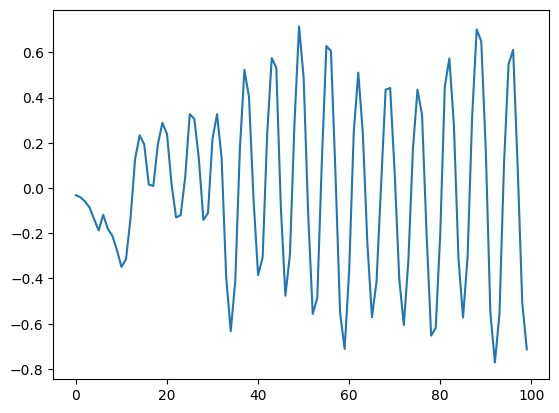

In [23]:
print(f'output shape: {out.shape}')
plt.plot(out[0].squeeze().numpy())
plt.show()

In [16]:
def evaluate(encoder, decoder, sashimi, context, seq_len):
    state = sashimi.default_state()
    context_len = len(context)
    context_output = []
    prediction_output = []
    with torch.no_grad():
        #print(context[0].unsqueeze(0).unsqueeze(0).shape)
        for i in tqdm(range(context_len)):
            y = encoder(context[i].unsqueeze(0).unsqueeze(0))
            y, state = sash.step(y, state)
            y = decoder(y, state)
            context_output.append(y.detach().cpu())
        
        y = context[-1].unsqueeze(0).unsqueeze(0)
        for i in tqdm(range(seq_len)):
            y = encoder(y)
            y, state = sash.step(y, state)
            y = decoder(y, state)
            prediction_output.append(y.detach().cpu())
        
    context_output = torch.stack(context_output, dim=1)
    prediction_output = torch.stack(prediction_output, dim=1)
    return context_output, prediction_output
            

In [52]:
t = np.linspace(0, 2, 32000)
context_len = 100
f = 2000
a = 0.5
full_context = np.sin(2 * np.pi * f * t) * a
short_context = torch.from_numpy(full_context)[:context_len].type(torch.float32)

In [53]:
context_pred, pred = evaluate(encoder, decoder, sash, short_context, 300)

torch.Size([1, 1])


100%|██████████| 300/300 [00:01<00:00, 265.62it/s]


In [54]:
print(f'context shape: {short_context.shape}')
print(f'context prediction: {context_pred.shape}')
print(f'prediction length: {pred.shape}')

context shape: torch.Size([100])
context prediction: torch.Size([1, 100, 1])
prediction length: torch.Size([1, 300, 1])


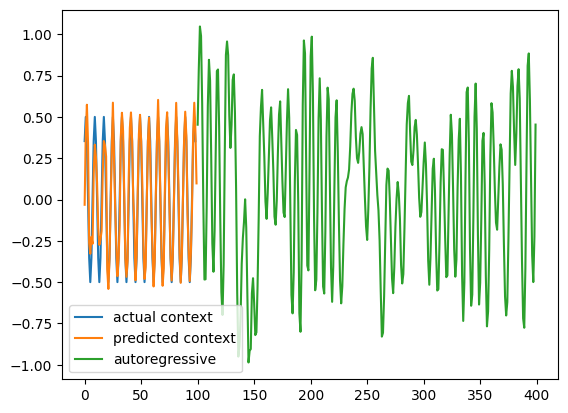

In [55]:
x = np.arange(len(short_context) + len(pred.squeeze()))
plt.plot(x[:len(short_context) -1], short_context[1:], label='actual context')
plt.plot(x[:len(short_context)], context_pred.squeeze().numpy(), label='predicted context')
plt.plot(x[len(short_context):], pred.squeeze().numpy(), label='autoregressive')
plt.legend()
plt.show()